### Exploration of the VinDr-Mammo Dataset

This notebook is the first in a series of notebooks designed to explore that VinDr datasets and select a subs-sample of the data inorder to replicate macaw2D on the dataset. This notebook will look at the various elements of the dataset and from here develop choices inorder to successfully recreate the macaw2D.

In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
base_dir = 'physionet.org/files/vindr-mammo/1.0.0/'
images_dir = os.path.join(base_dir, 'images')

FINDING_ANNOTATIONS = os.path.join(base_dir, 'finding_annotations.csv')
BREAST_LEVEL_ANNOTATIONS = os.path.join(base_dir, 'breast-level_annotations.csv')
METADATA = os.path.join(base_dir, 'metadata.csv')

<br>

### Let's Begin with Metadata View


In [3]:
annotations = pd.read_csv(BREAST_LEVEL_ANNOTATIONS)
meta_data = pd.read_csv(METADATA)
finding_anon = pd.read_csv(FINDING_ANNOTATIONS)

In [4]:
finding_anon.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
2,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,c83f780904f25eacb44e9030f32c66e1,R,CC,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,2279.179932,1166.510010,2704.439941,2184.260010,training
3,75e8e48933289d70b407379a564f8594,853b70e7e6f39133497909d9ca4c756d,893528bc38a0362928a89364f1b692fd,R,MLO,3518,2800,BI-RADS 3,DENSITY C,['Global Asymmetry'],BI-RADS 3,1954.270020,1443.640015,2589.760010,2193.810059,training
4,c3487424fee1bdd4515b72dc3fd69813,77619c914263eae44e9099f1ce07192c,318264c881bf12f2c1efe5f93920cc37,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Architectural Distortion'],BI-RADS 4,2172.300049,1967.410034,2388.699951,2147.159912,training


A few important pieces of information here:

1. Finding categories: this is an important column because it provides the categorization/classes for the dataset. We will be able to view it using the bounding box.
2. finding BI-RADS: This is another important feature because it details whether the detection is likely cancerous. We would use one of these as classification.


In [5]:
finding_anon.finding_birads.unique()

array(['BI-RADS 4', 'BI-RADS 3', 'BI-RADS 5', nan], dtype=object)

In [6]:
finding_anon.finding_birads.value_counts(dropna=False)

finding_birads
NaN          18357
BI-RADS 4      995
BI-RADS 3      893
BI-RADS 5      241
Name: count, dtype: int64

In [7]:
finding_anon.finding_categories.unique()

array(["['Mass']", "['Global Asymmetry']", "['Architectural Distortion']",
       "['Nipple Retraction', 'Mass']",
       "['Suspicious Calcification', 'Focal Asymmetry']",
       "['Focal Asymmetry']", "['Asymmetry']",
       "['Suspicious Calcification']",
       "['Suspicious Calcification', 'Architectural Distortion']",
       "['Suspicious Calcification', 'Mass']", "['Skin Thickening']",
       "['Suspicious Lymph Node']", "['Nipple Retraction', 'Asymmetry']",
       "['Skin Thickening', 'Mass']", "['Asymmetry', 'Mass']",
       "['Architectural Distortion', 'Asymmetry']",
       "['Suspicious Calcification', 'Asymmetry']",
       "['Nipple Retraction']",
       "['Suspicious Calcification', 'Nipple Retraction', 'Mass']",
       "['Skin Retraction', 'Nipple Retraction', 'Mass']",
       "['Focal Asymmetry', 'Mass']",
       "['Nipple Retraction', 'Skin Thickening', 'Mass']",
       "['Skin Retraction']",
       "['Suspicious Calcification', 'Architectural Distortion', 'Mass']",
  

In [8]:
finding_anon.breast_density.unique()

array(['DENSITY C', 'DENSITY D', 'DENSITY A', 'DENSITY B'], dtype=object)

In [9]:
finding_anon.breast_density.value_counts(normalize=True, dropna=False)

breast_density
DENSITY C    0.766133
DENSITY D    0.132627
DENSITY B    0.096310
DENSITY A    0.004930
Name: proportion, dtype: float64

In [10]:
finding_anon.breast_density.value_counts(dropna=False)

breast_density
DENSITY C    15695
DENSITY D     2717
DENSITY B     1973
DENSITY A      101
Name: count, dtype: int64

<br>

We will wish to consider the differences in the density of the dataset just because of the differences in their distribution.

### Checking the Differences in Image Dimensions.



In [11]:
finding_anon.width.unique()

array([2800, 2012, 2812, 2609, 2706, 2694, 2657, 2670, 2622, 2702, 2798,
       2782, 2750, 2766, 2718, 2606, 2638, 2734, 2654, 2686, 2754, 2724,
       2675, 2549, 2639, 2730, 2681, 2663, 2621, 2615, 2585, 2627, 2579,
       2700, 2597, 2736, 2633, 2645, 2778, 2772, 2742, 2802, 2808, 2796,
       2687, 2790, 2591, 2603, 2712, 2669, 2748, 2555, 2531, 2760, 2784,
       2651, 2567, 2543])

In [12]:
finding_anon.height.unique()

array([3518, 2812, 3580])

In [13]:
finding_anon.groupby(['width','height']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False)

,width,height,count
54,2800,3518,15475
0,2012,2812,3886
57,2812,3580,496
36,2718,3580,53
33,2702,3580,50
11,2606,3580,44
26,2670,3580,42
43,2750,3580,41
22,2654,3580,35
29,2686,3580,30


Note:

There are various combinations of the width and height for the images. For testing purposes, we will have to choose a sample. At the moment, the top 2 look substantial enough to provide a good basis for selecting them. Picking either will require little to no modification on the first test run.

In [14]:
finding_anon.groupby(['width','height']).size().reset_index().rename(columns={0:'count'}).sort_values('count', ascending=False).head()

,width,height,count
54,2800,3518,15475
0,2012,2812,3886
57,2812,3580,496
36,2718,3580,53
33,2702,3580,50


<br>

### Now lets visualize the images

The challenge with our dataset on this local drive is that we are not sure whether it is all complete. Let's see what dataset are actually available. I do this by checking with files exist and which dont by study.


In [15]:
images = []

for study in os.listdir(images_dir):
    if os.path.isdir( os.path.join(images_dir, study)):
        dir = os.path.join(images_dir, study)
        if len(os.listdir(dir)) > 1:
            downloaded_files = [ file for file in os.listdir(dir) if not file.endswith('.html') ]
            images.extend(downloaded_files)

In [16]:
len(images)

6466

<br>

We have a collection of 6466 images.

In [17]:
image_files = [ img.split('.')[0] for img in images ]

<br>

#### Finding Anon

In [18]:
available_images = finding_anon[finding_anon.image_id.isin(image_files)]

In [19]:
available_images.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
0,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,4e3a578fe535ea4f5258d3f7f4419db8,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2355.139893,1731.640015,2482.979980,1852.750000,training
1,48575a27b7c992427041a82fa750d3fa,26de4993fa6b8ae50a91c8baf49b92b0,dac39351b0f3a8c670b7f8dc88029364,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2386.679932,1240.609985,2501.800049,1354.040039,training
6,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,2f944efb1cb9579442df2d7fe6a579b7,L,CC,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2171.810059,439.584991,2403.370117,test
7,5683854eafabc34f6d854000d2ac6c2d,4ac33111294b83d43537cb8604b0808c,7385e8cf7b29764525c81de4aa1aebe4,L,MLO,3518,2800,BI-RADS 3,DENSITY C,['Mass'],BI-RADS 3,142.899002,2045.170044,417.876007,2265.879883,test
14,57674c2def92287668ed5bc51092fbef,080c6eda9556d5bf5c10e2299b1f6fbc,dc4694b543793f89c7003f4d52adbbcb,L,CC,3518,2800,BI-RADS 5,DENSITY C,['Architectural Distortion'],BI-RADS 5,405.056000,1599.650024,600.893982,1867.489990,training


In [20]:
available_images.breast_birads.value_counts()

breast_birads
BI-RADS 1    4305
BI-RADS 2    1537
BI-RADS 4     345
BI-RADS 3     325
BI-RADS 5     130
Name: count, dtype: int64

In [21]:
available_images.split.value_counts()

split
training    5249
test        1393
Name: count, dtype: int64

<br>

### Implementing a Sample Dataset

In [26]:
import torch
from torch.utils.data import Dataset

class MammoDataset(Dataset):

    def __init__(self, images_dir, data_mapping, transform = None, test=False):

        self.images_dir = images_dir
        self.data_mapping = data_mapping

    def __len__(self):
        return len(self.data_mapping)

    def __getitem__(self, index):
        image_name = os.path.join( self.images_dir, self.data_mapping.iloc[index, 0], self.data_mapping.iloc[index, 2] + '.dicom' )
        image = pydicom.dcmread(image_name)

        label = self.data_mapping.iloc[index, -6]

        return image.pixel_array, label

In [23]:
images_dir = os.path.join(base_dir, 'images')

data = MammoDataset(images_dir, available_images)

In [24]:
image, label = data[3100]

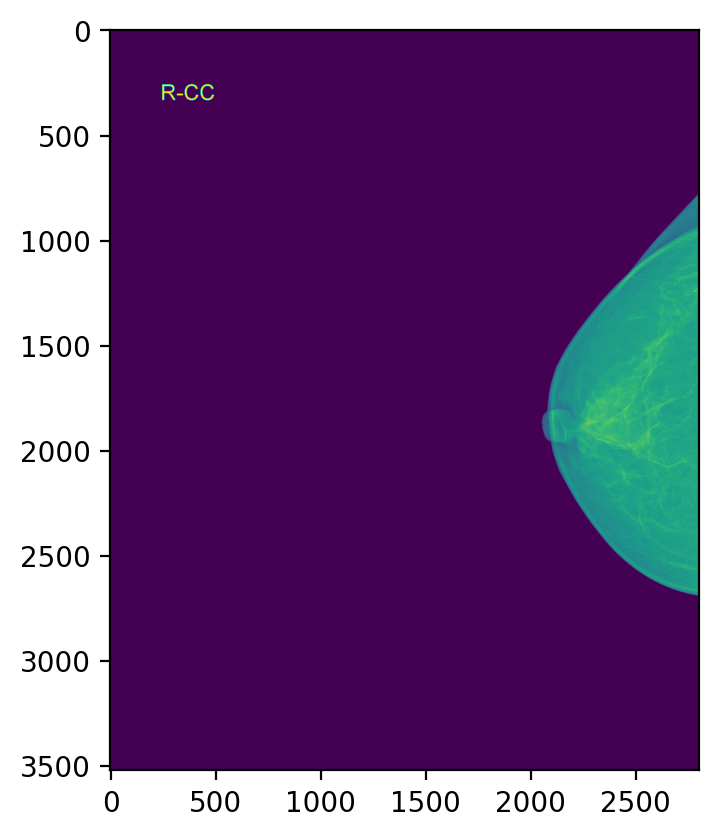

In [25]:
plt.imshow(image)    
plt.show()